In [35]:
import os
import requests
import json

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

from rouge import Rouge
import string, re


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoTokenizer,AutoModelForQuestionAnswering

In [36]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained(
    "deepset/roberta-base-squad2"
)
model = AutoModelForQuestionAnswering.from_pretrained(
    "deepset/roberta-base-squad2"
)


def read_hospitalityData(path):
    with open(path, "rb") as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict["data"]:
        for passage in group["paragraphs"]:
            context = passage["context"]
            for qa in passage["qas"]:
                question = qa["question"]
                if "plausible_answers" in qa.keys():
                    access = "plausible_answers"
                else:
                    access = "answers"
                for answer in qa["answers"]:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)
        
        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:           
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:                    
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []    
    for i in range(len(answers)-1):
        # append start/end token position using char_to_token method
       
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))        
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back +=1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})



def save_model(model_path):
    #model_path = 'data/benchmarks/bertuncased-custom'
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)



def ConvertIdstoAnswers(inputIds,startId,endId):
    answer=''
    results=[]
    for i in range(len(inputIds)):
        token=tokenizer.convert_ids_to_tokens(inputIds[i])      
        if endId[i] >= startId[i]:
            answer = token[startId[i]]
            for i in range(startId[i]+1, endId[i]+1):
                if token[i][0:2] == "##":               
                    answer += token[i][2:]                    
                else:
                    answer += " " + token[i]          
            results.append(answer)   
        else:
            results.append("None")  

    return results



In [37]:
#pytorch class
class hospitalityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):        
        return len(self.encodings.input_ids)-1

In [38]:

# Method for cleaning the prediction values
def normalize_text(s):
    """Typically, text processing steps include removing articles and punctuation and standardizing whitespace."""
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Method to compute  Avg EM evaluation
def compute_exact_match(model_out,reference):
    em = []    
    for i in range(len(model_out)):
        if normalize_text(model_out[i]) == normalize_text(reference[i]):
            em.append(1)
        else:
            em.append(0)    
    return sum(em)/len(em)
# Method to compute EM for each prediction
def compute_exact_match_eachPredictions(model_out,reference):
    em = []    
    for i in range(len(model_out)):
        if normalize_text(model_out[i]) == normalize_text(reference[i]):
            em.append([normalize_text(model_out[i]),normalize_text(reference[i]),1])
        else:
            em.append([normalize_text(model_out[i]),normalize_text(reference[i]),0])  
    return em

# Method to compute Avg Rouge score
def compute_rouge_evaulation(model_out,reference):    
    rouge = Rouge()
    return rouge.get_scores(model_out, reference, avg=True)

# Method to compute Rouge score for each prediction
def compute_rouge_evaulation_noavg(model_out,reference):    
    rouge = Rouge()
    return rouge.get_scores(model_out, reference)

In [39]:
# Loading training and validation dataset
(train_contexts, train_questions, train_answers) = \
    read_hospitalityData('data/f21mp_test.json')
    
(val_contexts, val_questions, val_answers) = \
    read_hospitalityData('data/f21mp_train.json')

In [40]:
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

train_encodings = tokenizer(train_contexts, train_questions,truncation=True, max_length=171,padding='max_length',return_tensors='pt')

val_encodings = tokenizer(val_contexts, val_questions, truncation=True,max_length=171, padding='max_length',return_tensors='pt')

# apply function to our data

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [41]:
train_dataset = hospitalityDataset(train_encodings)
val_dataset = hospitalityDataset(val_encodings)

In [42]:
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
acc = []


# initialize loop for progress bar
eval_loop = tqdm(val_loader)
training_losses=[]
eval_acc_avg = []
eval_acc_start = []
eval_acc_end = []
rouge_scores=[]
em_scores=[]

best_accuracy=.35

for epoch in range(10):
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    training_epoc_loss=0 
    loop = tqdm(train_loader, leave=True)    
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        
        # calculate loss for every parameter that needs grad update
        training_epoc_loss += loss.item() 
        
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        
        
        
    training_loss = training_epoc_loss/len(loop)
    training_losses.append(training_loss)

    # # EVALUATE
    model.eval()

    start_pos_numerator = []
    model_output_truth=[]
    start_pos_denom = []
    end_pos_numerator = []
    end_pos_denom = []
    for batch in eval_loop:   
    # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calculate accuracy for both and append to accuracy list
            start_pos_numerator.append((start_pred == start_true).sum().item())
            start_pos_denom.append(len(start_pred))
            end_pos_numerator.append((end_pred == end_true).sum().item())
            end_pos_denom.append(len(end_pred))

            # acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            # acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
            
            reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
            model_output_truth.append([model_out[0],reference[0]])
    start_accuracy = sum(start_pos_numerator)/sum(start_pos_denom)
    end_accuracy = sum(end_pos_numerator)/sum(end_pos_denom)
    avg_acc = np.mean([start_accuracy,end_accuracy])
    eval_acc_avg.append(avg_acc)
    eval_acc_start.append(start_accuracy)
    eval_acc_end.append(end_accuracy)

    
    
    model_output_truth = np.array(model_output_truth)
    model_out = model_output_truth[:,0]
    reference = model_output_truth[:,1]
   
    rouge_score=compute_rouge_evaulation(model_out,reference)
    #print(f"model_out {model_out} reference {reference} rouge_score: {rouge_score}")    
    rouge_scores.append(rouge_score['rouge-l']['f'])
    em_score=compute_exact_match(model_out,reference)
    em_scores.append(em_score)
    #print(f"saving model .... Best accuracy {avg_acc}")
    #print(f"EPOCH {epoch} Training Loss {training_loss} Eval Avg Acc: {avg_acc} Eval Start Pos Acc: {start_accuracy} Eval End Pos Acc: {end_accuracy} Exact Match: {em_score} Rouge Score: {rouge_score}")    
    if avg_acc>best_accuracy:
        best_accuracy=avg_acc
        save_model('data/benchmarks/bestmodels/bert-large-uncased-whole-word-masking-finetuned-squad/')
        print(f"saving model .... Best accuracy {best_accuracy}")


  0%|          | 0/92 [00:00<?, ?it/s]<ipython-input-37-2fe28b62591e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

saving model .... Best accuracy 0.4565217391304348


Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

saving model .... Best accuracy 0.5


Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

saving model .... Best accuracy 0.5108695652173914


Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

saving model .... Best accuracy 0.5434782608695652


Epoch 9: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s, loss=1.71]


In [43]:
import pandas as pd
model_metrics=pd.DataFrame({
    "epocs":list(range(10)),
    "training_loss": training_losses,
    "avg_accuracy":eval_acc_avg,
    "exact_match": em_scores,
    "rouge_score": rouge_scores
})
model_metrics = model_metrics.set_index("epocs")
model_metrics

,training_loss,avg_accuracy,exact_match,rouge_score
epocs,,,,
0,2.490481,0.456522,0.369565,0.525526
1,1.545998,0.500000,0.391304,0.527147
2,1.273418,0.472826,0.402174,0.580361
3,1.171650,0.489130,0.347826,0.541793
4,1.240975,0.510870,0.402174,0.573906
5,0.672804,0.543478,0.467391,0.647362
6,0.576727,0.505435,0.380435,0.657657
7,0.481731,0.505435,0.326087,0.559607
8,0.485517,0.500000,0.413043,0.639449


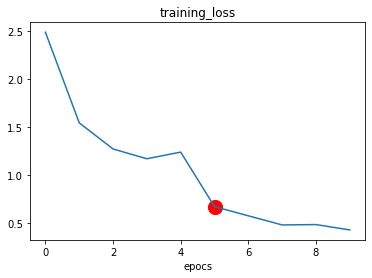

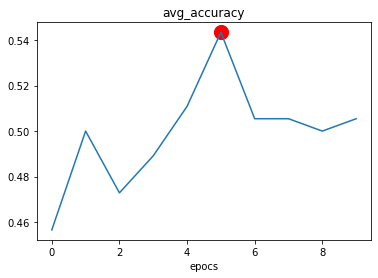

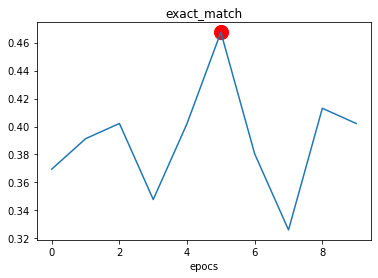

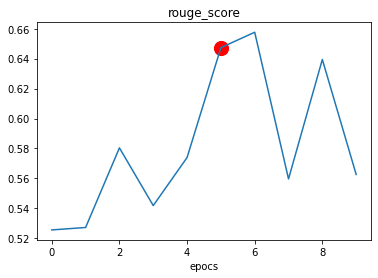

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
for col in model_metrics.columns:
    model_metrics[col].plot(title=col)
    # if col=="exact_match":
    #     plt.axhline(y=0.45,color="r",)
    plt.scatter(5,model_metrics[col][5],color="r",s=200)
    #plt.text(0,0.55, "{:.0f}".format(0.55), color="red", ha="right", va="center")
    plt.show()

In [13]:

# model_out=ConvertIdstoAnswers(input_ids,start_pred,end_pred)
# reference=ConvertIdstoAnswers(input_ids,start_true,end_true)
# print('\nModel output{}'.format(model_out))
# print('\nReference {}'.format(reference))

print("\nThe accuracy of start and end tokens with respect to true position: {}".format(acc))
print("\nRouge Evaulation: {}".format(compute_rouge_evaulation(model_output_truth[0][0],model_output_truth[0][1])))
print("\nExact Match: {}".format(compute_exact_match(model_output_truth[0][0],model_output_truth[0][1])))


The accuracy of start and end tokens with respect to true position: []

Rouge Evaulation: {'rouge-1': {'r': 0.7777777777777778, 'p': 1.0, 'f': 0.8749999950781251}, 'rouge-2': {'r': 0.75, 'p': 1.0, 'f': 0.8571428522448981}, 'rouge-l': {'r': 0.7777777777777778, 'p': 1.0, 'f': 0.8749999950781251}}

Exact Match: 0.13953488372093023
